In [22]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import glob
import PIL
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import active_semi_clustering
import cv2 

2022-06-01 10:36:21.054071: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-01 10:36:21.054092: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/home/roberteichner/anaconda3/envs/con_clust/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [23]:
import skimage
from skimage import io
from skimage import segmentation
import matplotlib.image as mpimg
from skimage import filters
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from skimage import exposure

In [10]:
builder = tfds.builder('voc/2007')
builder.download_and_prepare()
datasets = builder.as_dataset()
train_data, val_data, test_data = datasets['train'], datasets['validation'], datasets['test']

In [133]:
t_images = [ x['image'] for x in train_data] 

In [31]:
dataframe_test = tfds.as_dataframe(train_data)

In [32]:
dataframe_test.head()

,image,image/filename,labels,labels_no_difficult,objects/bbox,objects/is_difficult,objects/is_truncated,objects/label,objects/pose
0,"[[[101, 102, 32], [131, 132, 64], [106, 108, 4...",b'007308.jpg',"[12, 14]","[12, 14]","[[0.14375, 0.043701798, 0.97083336, 0.7763496]...","[False, False, False, True]","[False, False, True, True]","[12, 14, 12, 14]","[4, 4, 4, 4]"
1,"[[[255, 255, 251], [255, 255, 251], [255, 255,...",b'006362.jpg',[6],[6],"[[0.074666664, 0.08, 0.88533336, 0.812], [0.30...","[False, False]","[False, True]","[6, 6]","[4, 4]"
2,"[[[169, 166, 161], [167, 164, 159], [166, 165,...",b'007991.jpg',[2],[2],"[[0.264, 0.006, 1.0, 1.0]]",[False],[False],[2],[2]
3,"[[[111, 118, 4], [112, 119, 5], [114, 119, 3],...",b'005363.jpg',[16],[16],"[[0.138, 0.0053333333, 0.998, 0.9813333]]",[False],[True],[16],[0]
4,"[[[156, 132, 128], [112, 91, 86], [127, 107, 1...",b'001612.jpg',[18],[18],"[[0.3153153, 0.314, 0.8318318, 0.932]]",[False],[False],[18],[4]


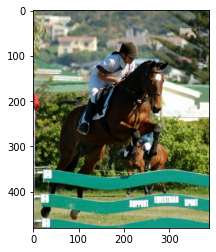

In [12]:
tmp = images[0]
#resized_img = resize(tmp, (128*4, 64*4))
plt.imshow(tmp)

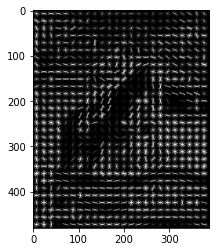

In [13]:
fd, hog_image = hog(tmp, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), visualize=True, channel_axis=-1)
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image_rescaled, cmap="gray")
plt.show()

In [14]:
fd.shape

(5760,)

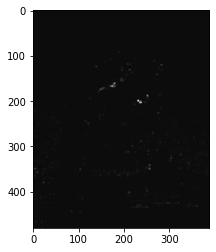

In [15]:
image_copy = np.copy(tmp)
gray = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)

# Detect corners 
dst = cv2.cornerHarris(gray, 2, 3, 0.04)

# Dilate corner image to enhance corner points
dst = cv2.dilate(dst,None)

plt.imshow(dst, cmap='gray')

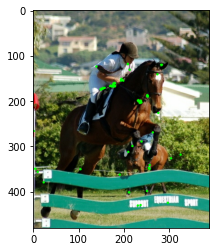

In [16]:
# This value vary depending on the image and how many corners you want to detect
# Try changing this free parameter, 0.1, to be larger or smaller and see what happens
thresh = 0.1*dst.max()

# Create an image copy to draw corners on
corner_image = np.copy(image_copy)

# Iterate through all the corners and draw them on the image (if they pass the threshold)
for j in range(0, dst.shape[0]):
    for i in range(0, dst.shape[1]):
        if(dst[j,i] > thresh):
            # image, center pt, radius, color, thickness
            cv2.circle( corner_image, (i, j), 1, (0,255,0), 1)

plt.imshow(corner_image)

In [77]:
dst.shape

(480, 389)

In [39]:
def getCannyFeature(tmp_image):
    img_blur = cv2.cvtColor(tmp_image, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_blur, (3,3), 0)
    edges = cv2.Canny(img_blur, 100, 200)
    return edges

In [84]:
def getHog(tmp_image):
    fd = hog(tmp_image, orientations=8, pixels_per_cell=(16, 16),
                cells_per_block=(1, 1), channel_axis=-1)
    return fd

In [3]:
from sklearn.cluster import KMeans

In [117]:
img_data = dataframe_test['image']

In [124]:
inverse = np.array([[0, 1, 5, 6, 14, 15, 27, 28],
                    [2, 4, 7, 13, 16, 26, 29, 42],
                    [3, 8, 12, 17, 25, 30, 41, 43],
                    [9, 11, 18, 24, 31, 40, 44, 53],
                    [10, 19, 23, 32, 39, 45, 52, 54],
                    [20, 22, 33, 38, 46, 51, 55, 60],
                    [21, 34, 37, 47, 50, 56, 59, 61],
                    [35, 36, 48, 49, 57, 58, 62, 63]]).astype(int)
zigzag_flat = np.argsort(inverse, axis=None).astype(int)


def color_layout_descriptor(im):
    # numpy is a bit faster than using tensors
    im = np.array(im)
    # could do these as a hyperparameter
    rows = 8
    columns = 8
    small_image = np.zeros((rows, columns, 3))
    height, width = im.shape[:2]
    percentage_w = width / columns
    percentage_h = height / rows
    for row in range(rows):
        for column in range(columns):
            # Note this partion should propably be checked against a reference implementation. However the difference should be minimal
            portion = im[int(percentage_h * row):int(percentage_h * (row + 1)),
                      int(percentage_w * column):int(percentage_w * (column + 1))]
            small_image[row, column] = np.mean(np.mean(portion, axis=0), axis=0)
    small_image = cv2.cvtColor(small_image.astype(np.uint8), cv2.COLOR_BGR2YCrCb)
    y, cr, cb = cv2.split(small_image)
    dct_y = cv2.dct(y.astype(np.float32))
    dct_cb = cv2.dct(cb.astype(np.float32))
    dct_cr = cv2.dct(cr.astype(np.float32))
    return np.concatenate((dct_y.flatten()[zigzag_flat], dct_cb.flatten()[zigzag_flat], dct_cr.flatten()[zigzag_flat]))

In [137]:
def add_features_to_dataset(dataset,cachename):
    images = dataset.map(lambda x: x["image"])
    feature_sets = []
    images = dataset.map(lambda x: x["image"])
    cld_features = images.map(lambda x: tf.py_function(func=color_layout_descriptor, inp=[x], Tout=np.float32),
                             num_parallel_calls=tf.data.experimental.AUTOTUNE).cache("data/"+cachename+"_cld" if cachename!=None else '').prefetch(
    tf.data.experimental.AUTOTUNE)
    feature_sets.append(cld_features)
    return cld_features
feature_vec = add_features_to_dataset(train_data,"train")

In [139]:
feature_vec

<PrefetchDataset element_spec=TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)>

In [12]:
from sklearn.datasets import make_multilabel_classification
from sklearn.cluster import KMeans

In [7]:
mult_data_X, mult_data_Y = make_multilabel_classification(n_samples = 1000, n_features=4, n_classes=20, n_labels=1, allow_unlabeled=False)

In [14]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(mult_data_X)
Z = kmeans.predict(mult_data_X)

In [78]:
from sklearn.neighbors import KNeighborsClassifier

def get_KNN_points(numb_neigh, query_point, X, Y):
    neigh = KNeighborsClassifier(n_neighbors=numb_neigh, metric='cosine').fit(X,Y)
    dist_arr, ind_array = neigh.kneighbors(X=query_point)
    return ind_array.flatten('c')

In [59]:
mult_data_X.shape

q_point =  mult_data_X[6].reshape(1, -1)

In [60]:
q_point

array([[15., 11.,  7., 13.]])

In [79]:
neigh_array = get_KNN_points(500, q_point, mult_data_X, mult_data_Y)

In [80]:
kmeans = KMeans(n_clusters=20, random_state=0).fit(mult_data_X[neigh_array])
Z2 = kmeans.predict(mult_data_X[neigh_array])

In [83]:
print(Z[neigh_array] - Z2)

[  1  -2  -2  -2 -16   1   0 -16 -18 -18  -2  -2 -16   1 -17  -2  10  -2
 -16  -2  -2 -17 -17   6  -8  -2  -2   0  -2   1 -18  10 -18  -2 -12  -8
 -17 -18  -2 -16  -2  -4  -2 -17  -2 -16  -2   1 -17 -14   1   6 -17   1
  -8  10   6   2 -18   1   1  10  -4 -16 -17 -17   1  -8   1  -2   6  -2
  -4   6  -4  10   2  -2  -4 -17   1   1  10  12 -16  -2 -12   2  -2 -16
   1 -16 -17 -10   2  -1  -7   2 -10   6   4   1  -2   6 -14 -10 -18  -7
   6 -17  -2 -18   6  -4   2   1  -4  -7  -8   1  -1  -2  16  -1  -4   6
   6  -8   5  -8  -4   1 -18   2 -12 -18 -13   6   1  -5 -17 -17  -1  10
   2   6  -4  -2  10   4 -12  -8  -8   2   2   1  -2   6 -17   2   1  -2
 -13  -1   6   2  -2   7 -10  -4   4   4  -7  -2  -2   2   2   1  -7  -5
   8   6   6  -4  13   6  -1   1  -4  -4  10  -7  -8  -2   2  -2   6   1
   6  -2  -1  -2  -8 -17   2   2  12  12 -17   1   1  -5   2   1 -17  -4
   6  -2 -17  -8 -12 -18   2   6   5  -5   8  -4  -8  -4   1 -10  -2   1
  -7   4  -1   5  -8   2   1  -8 -10   2   6  -4 -1